<a href="https://colab.research.google.com/github/arndmghsh/Time-series-prediction-shop-sales/blob/master/ShopID126_Prod2_2_Promo2_498.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving shopid126_prod2_2_promo2_498_paidtime.csv to shopid126_prod2_2_promo2_498_paidtime.csv
User uploaded file "shopid126_prod2_2_promo2_498_paidtime.csv" with length 141732 bytes


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime

In [0]:
df = pd.read_csv('shopid126_prod2_2_promo2_498_paidtime.csv')
# Look at the data
display(df.head())

# look at shape of data
display(df.shape)

# look at data types. Ideally look at all rows. Only look at first five here for minimal output.
display(df.iloc[:5,:5].dtypes)

# see if any columns have nulls. Ideally look at all rows. Only look at first five here for minimal output.
display(df.iloc[:5,:5].isnull().any())

# display descriptive statistics
# display(df2.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))



,computerid,transactionid,paidtime
0,589,3142,2018-12-20 21:02:46.0
1,589,3155,2018-12-25 13:36:29.0
2,589,3161,2018-12-26 21:25:55.0
3,589,3186,2019-01-07 21:02:49.0
4,589,3204,2019-01-16 20:50:57.0


(3938, 3)

computerid        int64
transactionid     int64
paidtime         object
dtype: object

computerid       False
transactionid    False
paidtime         False
dtype: bool

In [0]:
df.iloc[:3,:3]

,computerid,transactionid,paidtime
0,589,3142,2018-12-20 21:02:46.0
1,589,3155,2018-12-25 13:36:29.0
2,589,3161,2018-12-26 21:25:55.0


In [0]:
df = df.drop(['transactionid'], axis=1)
df.head()

,computerid,paidtime
0,589,2018-12-20 21:02:46.0
1,589,2018-12-25 13:36:29.0
2,589,2018-12-26 21:25:55.0
3,589,2019-01-07 21:02:49.0
4,589,2019-01-16 20:50:57.0


In [0]:
df.paidtime = pd.to_datetime(df.paidtime)
df.paidtime = df.paidtime.dt.date
df.head()

,computerid,paidtime
0,589,2018-12-20
1,589,2018-12-25
2,589,2018-12-26
3,589,2019-01-07
4,589,2019-01-16


In [0]:
# Rename columns
df = df.rename(columns = {'paidtime': 'ds', 'computerid': 'ts'})
df.head()

,ts,ds
0,589,2018-12-20
1,589,2018-12-25
2,589,2018-12-26
3,589,2019-01-07
4,589,2019-01-16


In [0]:
# Group data by number of listings per date
df_example = df.groupby(by = 'ds').agg({'ts': 'count'})
df_example.head()

,ts
ds,
2018-12-11,20
2018-12-12,31
2018-12-13,36
2018-12-14,19
2018-12-15,57


In [0]:
# Set frequency of time series
df_example = df_example.asfreq(freq='1D')
df_example.head()

,ts
ds,
2018-12-11,20
2018-12-12,31
2018-12-13,36
2018-12-14,19
2018-12-15,57


In [0]:
# Sort the values
df_example = df_example.sort_index(ascending = True)
df_example.head()

,ts
ds,
2018-12-11,20
2018-12-12,31
2018-12-13,36
2018-12-14,19
2018-12-15,57


In [0]:
df_example.isnull().any()

ts    False
dtype: bool

In [0]:
# Fill the NaN values with 0
df_example = df_example.fillna(value = 0)
df_example.tail()

,ts
ds,
2019-02-24,66
2019-02-25,38
2019-02-26,35
2019-02-27,41
2019-02-28,44


## Plot the Time Series

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


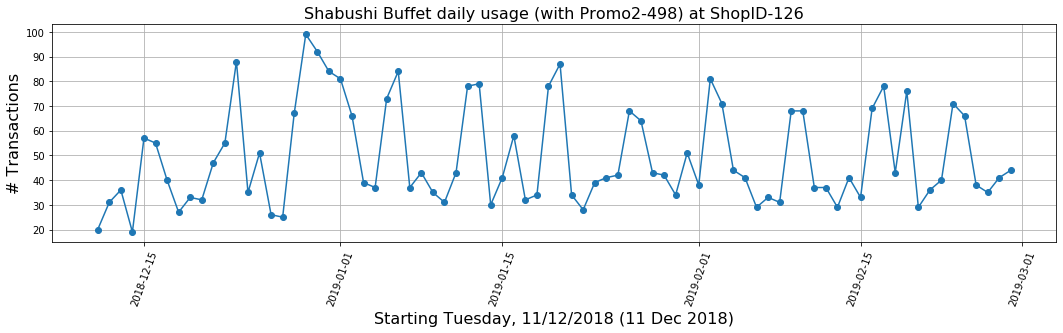

In [0]:
# # Plot time series data
# f, ax = plt.subplots(1,1)
# ax.plot(df_example['ts'])

# # Add title
# ax.set_title('Time-series graph for 1 time-series example')

# # Rotate x-labels
# ax.tick_params(axis = 'x', rotation = 45)

# # Show graph
# plt.show()
# plt.close()

fig, ax = plt.subplots(figsize = (18,4));
ax.plot(df_example['ts'], marker='o')
# plt.xticks(np.arange(min(a.day_num), max(a.day_num)+1, 1.0))
plt.grid();
ax.tick_params(axis = 'x', rotation = 70)
ax.set_title('Shabushi Buffet daily usage (with Promo2-498) at ShopID-126', fontsize=16)
ax.set_xlabel('Starting Tuesday, 11/12/2018 (11 Dec 2018)', fontsize=16);
ax.set_ylabel('# Transactions', fontsize=16);

## Stationarity of the time series

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Input:
    df: Dataframe
    ts: string. Represents the column in the dataframe df
    
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

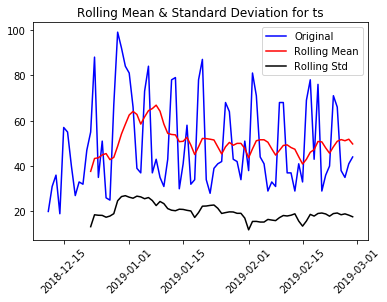

Results of Dickey-Fuller Test:
Test Statistic                 -3.036933
p-value                         0.031586
# Lags Used                     8.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [0]:
test_stationarity(df = df_example, ts = 'ts')

**As p-value<0.05 (5%), we can reject the null hypthesis H0 (which says the data is non-stationary). Therefore, our data is quite stationary.**

## Decomposition: trend, seasonality, residuals


In [0]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series data
  """
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
  plt.show()
  plt.close()
  
  return

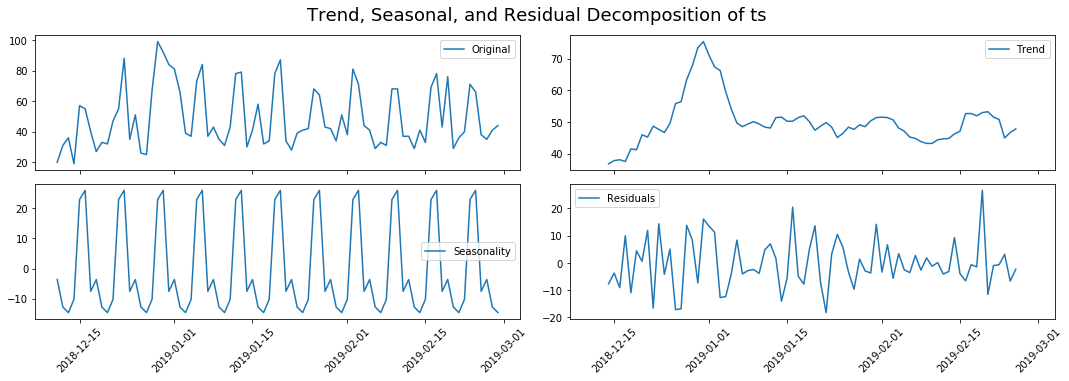

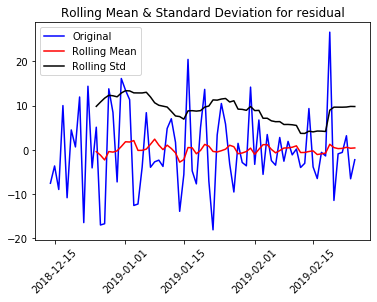

Results of Dickey-Fuller Test:
Test Statistic                -5.666191e+00
p-value                        9.140203e-07
# Lags Used                    5.000000e+00
Number of Observations Used    6.800000e+01
Critical Value (1%)           -3.530399e+00
Critical Value (5%)           -2.905087e+00
Critical Value (10%)          -2.590001e+00
dtype: float64


In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_example['ts'], freq = 7)

df_example.loc[:,'trend'] = decomposition.trend
df_example.loc[:,'seasonal'] = decomposition.seasonal
df_example.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_example, 
                   ts = 'ts', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = df_example.dropna(), ts = 'residual')

## ARIMA prediction


**ARIMA = Auto-Regressive Integrated Moving Average**.   
**Assumptions.** The time-series is stationary.  
**Depends on:**  
  **1. Number of AR (Auto-Regressive) terms (p).**  
  **2. Number of I (Integrated or Difference) terms (d).**  
  **3. Number of MA (Moving Average) terms (q).** 


**How do we determine p, d, and q?**
For p and q, we can use ACF and PACF plots (below).

**Autocorrelation Function (ACF).** Correlation between the time series with a lagged version of itself (e.g., correlation of Y(t) with Y(t-1)).

**Partial Autocorrelation Function (PACF).** Additional correlation explained by each successive lagged term.

**How do we interpret ACF and PACF plots?**
- p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
- q – Lag value where the ACF chart crosses the upper confidence interval for the first time.


In [0]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


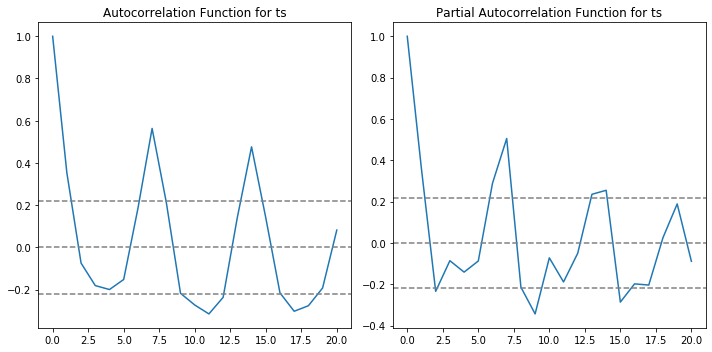

In [0]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

# determine ACF and PACF
lag_acf = acf(np.array(df_example['ts']), nlags = 20)
lag_pacf = pacf(np.array(df_example['ts']), nlags = 20)

# plot ACF and PACF
plot_acf_pacf(df = df_example, ts = 'ts')

In [0]:
def run_arima_model(df, ts, p, d, q):
  """
  Run ARIMA model
  """
  from statsmodels.tsa.arima_model import ARIMA

  # fit ARIMA model on time series
  model = ARIMA(df[ts], order=(p, d, q))  
  results_ = model.fit(disp=-1)  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[ts][-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[ts]))
  
  # plot fit
  plt.plot(df[ts])
  plt.plot(results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))
  
  plt.grid()
  plt.show()
  plt.close()
  
  return results_

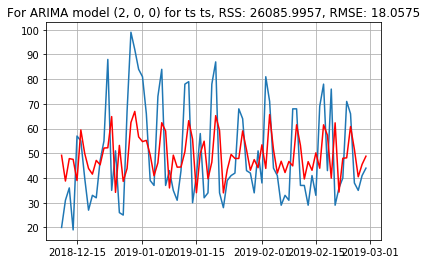

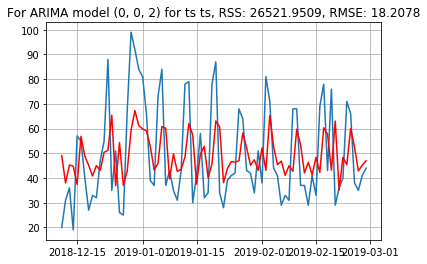

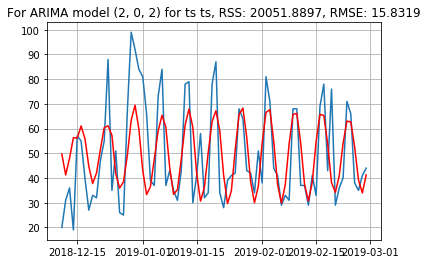

In [0]:
# AR model with 0th order differencing - ARIMA (2,0,0)
model_AR = run_arima_model(df = df_example, 
                           ts = 'ts', 
                           p = 2, 
                           d = 0, 
                           q = 0)

# MA model with 0th order differencing - ARIMA (0,0,2)
model_MA = run_arima_model(df = df_example, 
                           ts = 'ts', 
                           p = 0, 
                           d = 0, 
                           q = 2)

# ARMA model with 0th order differencing - ARIMA (2,0,2)
model_MA = run_arima_model(df = df_example, 
                           ts = 'ts', 
                           p = 2, 
                           d = 0, 
                           q = 2)

# # ARIMA model with 1st order differencing - ARIMA (2,1,2)
# model_MA = run_arima_model(df = df_example, 
#                            ts = 'ts', 
#                            p = 2, 
#                            d = 1, 
#                            q = 2)

## Prediction using Facebook Prophet
It uses statisticaltools for TSA. At its core, the Prophet procedure is an additive regression model with four main components:
1.   A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data
2.  A yearly seasonal component modeled using Fourier series.
1.   A weekly seasonal component using dummy variables.
2.   A user-provided list of important holidays.
1.   Can do MCMC sampling









In [0]:
!pip install pystan
!pip install fbprophet
from fbprophet import Prophet

In [0]:
def days_between(d1, d2):
    """Calculate the number of days between two dates.  D1 is start date (inclusive) and d2 is end date (inclusive)"""
    d1 = datetime.datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days + 1)

In [0]:
display(df_example.head())
display(df_example.shape)
# Take first 60 samples for training, remaining 20 for testing
display(df_example.iloc[59,:])
display(df_example.tail())

,ts,trend,seasonal,residual
ds,,,,
2018-12-11,20,NaN,-3.645269,NaN
2018-12-12,31,NaN,-12.745269,NaN
2018-12-13,36,NaN,-14.602412,NaN
2018-12-14,19,36.857143,-10.219295,-7.637848
2018-12-15,57,37.857143,22.858627,-3.715770


(80, 4)

ts          31.000000
trend       43.857143
seasonal   -10.219295
residual    -2.637848
Name: 2019-02-08 00:00:00, dtype: float64

,ts,trend,seasonal,residual
ds,,,,
2019-02-24,66,46.714286,25.910575,-6.624861
2019-02-25,38,47.857143,-7.556957,-2.300186
2019-02-26,35,NaN,-3.645269,NaN
2019-02-27,41,NaN,-12.745269,NaN
2019-02-28,44,NaN,-14.602412,NaN


In [0]:
# Inputs for query

date_column = 'dt'
metric_column = 'ts'
table = df_example
start_training_date = '2018-12-11'
end_training_date = '2019-02-08'
start_forecasting_date = '2019-02-09'
end_forecasting_date = '2019-02-28'
year_to_estimate = '2018'

# Inputs for forecasting

# future_num_points
# If doing different time intervals, change future_num_points
future_num_points = days_between(start_forecasting_date, end_forecasting_date)

cap = None # 2e6

# growth: default = 'linear'
# Can also choose 'logistic'
growth = 'linear'

# n_changepoints: default = 25, uniformly placed in first 80% of time series
n_changepoints = 25 

# changepoint_prior_scale: default = 0.05
# Increasing it will make the trend more flexible
changepoint_prior_scale = 0.05 

# changpoints: example = ['2016-01-01']
changepoints = None 

# holidays_prior_scale: default = 10
# If you find that the holidays are overfitting, you can adjust their prior scale to smooth them
holidays_prior_scale = 10 

# interval_width: default = 0.8
interval_width = 0.8 

# mcmc_samples: default = 0
# By default Prophet will only return uncertainty in the trend and observation noise.
# To get uncertainty in seasonality, you must do full Bayesian sampling. 
# Replaces typical MAP estimation with MCMC sampling, and takes MUCH LONGER - e.g., 10 minutes instead of 10 seconds.
# If you do full sampling, then you will see the uncertainty in seasonal components when you plot:
mcmc_samples = 0

# holiday: default = None
# thanksgiving = pd.DataFrame({
#   'holiday': 'thanksgiving',
#   'ds': pd.to_datetime(['2014-11-27', '2015-11-26',
#                         '2016-11-24', '2017-11-23']),
#   'lower_window': 0,
#   'upper_window': 4,
# })
# christmas = pd.DataFrame({
#   'holiday': 'christmas',
#   'ds': pd.to_datetime(['2014-12-25', '2015-12-25', 
#                         '2016-12-25','2017-12-25']),
#   'lower_window': -1,
#   'upper_window': 0,
# })
# holidays = pd.concat((thanksgiving,christmas))
holidays = None

daily_seasonality = True

In [0]:
display(df_example.head())
df_prophet=df_example[['ts']][:60]
df_prophet.size

,ts,trend,seasonal,residual
ds,,,,
2018-12-11,20,NaN,-3.645269,NaN
2018-12-12,31,NaN,-12.745269,NaN
2018-12-13,36,NaN,-14.602412,NaN
2018-12-14,19,36.857143,-10.219295,-7.637848
2018-12-15,57,37.857143,22.858627,-3.715770


60

In [0]:
# df_prophet=df_prophet.reset_index()

In [0]:
# df_prophet = df_prophet.rename(columns = {'ds': 'ds', 'ts': 'y'})
# display(df_prophet)
# display(type(df_prophet['ds'][0]))
# # Change 'ds' type from datetime to date (necessary for FB Prophet)
# df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
# type(df_prophet['ds'][0])

In [0]:
# get relevant data - note: could also try this with ts_log_diff
df_prophet = df_example[['ts']] # can try with ts_log_diff

# reset index
df_prophet = df_prophet.reset_index()

# rename columns
df_prophet = df_prophet.rename(columns = {'ds': 'ds', 'ts': 'y'}) # can try with ts_log_diff

# Change 'ds' type from datetime to date (necessary for FB Prophet)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Change 'y' type to numeric (necessary for FB Prophet)
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='ignore')

# Remove any outliers
# df.loc[(df_['ds'] > '2016-12-13') & (df_['ds'] < '2016-12-19'), 'y'] = None

In [0]:
def create_daily_forecast(df,
#                           cap,
                          holidays,
                          growth,
                          n_changepoints = 25,
                          changepoint_prior_scale = 0.05,
                          changepoints = None,
                          holidays_prior_scale = 10,
                          interval_width = 0.8,
                          mcmc_samples = 1,
                          future_num_points = 10, 
                          daily_seasonality = True):
  """
  Create forecast
  """
  
  # Create copy of dataframe
  df_ = df.copy()

  # Add in growth parameter, which can change over time
  #     df_['cap'] = max(df_['y']) if cap is None else cap

  # Create model object and fit to dataframe
  m = Prophet(growth = growth,
              n_changepoints = n_changepoints,
              changepoint_prior_scale = changepoint_prior_scale,
              changepoints = changepoints,
              holidays = holidays,
              holidays_prior_scale = holidays_prior_scale,
              interval_width = interval_width,
              mcmc_samples = mcmc_samples, 
              daily_seasonality = daily_seasonality)

  # Fit model with dataframe
  m.fit(df_)

  # Create dataframe for predictions
  future = m.make_future_dataframe(periods = future_num_points)
  #     future['cap'] = max(df_['y']) if cap is None else cap

  # Create predictions
  fcst = m.predict(future)

  # Plot
  m.plot(fcst);
  m.plot_components(fcst)

  return fcst

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


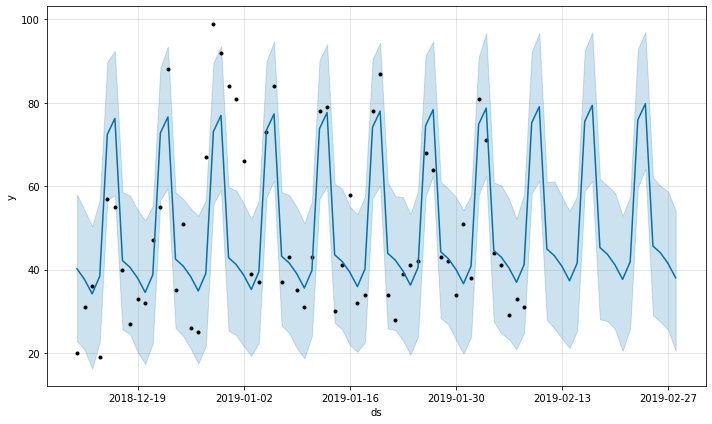

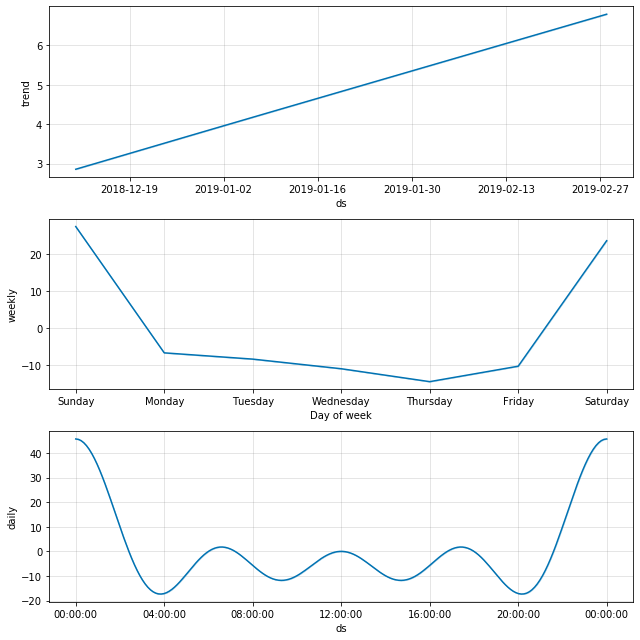

In [0]:
fcst = create_daily_forecast(df_prophet[:60],
#                              cap,
                             holidays,
                             growth,
                             n_changepoints,
                             changepoint_prior_scale,
                             changepoints, 
                             holidays_prior_scale,
                             interval_width,
                             mcmc_samples,
                             future_num_points, 
                             daily_seasonality)

In [0]:
def calculate_mape(y_true, y_pred):
    """ Calculate mean absolute percentage error (MAPE)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_mpe(y_true, y_pred):
    """ Calculate mean percentage error (MPE)"""
    return np.mean((y_true - y_pred) / y_true) * 100

def calculate_mae(y_true, y_pred):
    """ Calculate mean absolute error (MAE)"""
    return np.mean(np.abs(y_true - y_pred)) * 100

def calculate_rmse(y_true, y_pred):
    """ Calculate root mean square error (RMSE)"""
    return np.sqrt(np.mean((y_true - y_pred)**2))

def print_error_metrics(y_true, y_pred):
    print('MAPE: %f'%calculate_mape(y_true, y_pred))
    print('MPE: %f'%calculate_mpe(y_true, y_pred))
    print('MAE: %f'%calculate_mae(y_true, y_pred))
    print('RMSE: %f'%calculate_rmse(y_true, y_pred))
    return

In [0]:
fcst['yhat'].size

80

In [0]:
df_prophet['y'].size

80

In [0]:
# Test RMSE
print_error_metrics(y_true = df_prophet['y'][-future_num_points:], y_pred = fcst['yhat'][-future_num_points:])

MAPE: 16.958461
MPE: -10.435080
MAE: 782.237949
RMSE: 10.343529


## LSTM for Regression
* [Link 1](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
* [Link 2](https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f)
* [Link 3](http://adventuresinmachinelearning.com/recurrent-neural-networks-lstm-tutorial-tensorflow/)

In [0]:
def do_lstm_model(df, 
                  ts, 
                  look_back, 
                  epochs, 
                  type_ = None, 
                  train_fraction = 0.67):
  """
   Create LSTM model
   Source: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
  """
  # Import packages
  import numpy
  import matplotlib.pyplot as plt
  from pandas import read_csv
  import math
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.metrics import mean_squared_error

  # Convert an array of values into a dataset matrix
  def create_dataset(dataset, look_back=1):
    """
    Create the dataset
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), 0]
      dataX.append(a)
      dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

  # Fix random seed for reproducibility
  numpy.random.seed(7)

  # Get dataset
  dataset = df[ts].values
  dataset = dataset.astype('float32')

  # Normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset.reshape(-1, 1))
  
  # Split into train and test sets
  train_size = int(len(dataset) * train_fraction)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
  # Reshape into X=t and Y=t+1
  look_back = look_back
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  
  # Reshape input to be [samples, time steps, features]
  if type_ == 'regression with time steps':
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  elif type_ == 'stacked with memory between batches':
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  else:
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
  # Create and fit the LSTM network
  batch_size = 1
  model = Sequential()
  
  if type_ == 'regression with time steps':
    model.add(LSTM(4, input_shape=(look_back, 1)))
  elif type_ == 'memory between batches':
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  elif type_ == 'stacked with memory between batches':
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  else:
    model.add(LSTM(4, input_shape=(1, look_back)))
  
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    for i in range(100):
      model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
      model.reset_states()
  else:
    model.fit(trainX, 
              trainY, 
              epochs = epochs, 
              batch_size = 1, 
              verbose = 2)
  
  # Make predictions
  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    trainPredict = model.predict(trainX, batch_size=batch_size)
    testPredict = model.predict(testX, batch_size=batch_size)
  else:
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
  
  # Invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  
  # Calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  
  # Shift train predictions for plotting
  trainPredictPlot = numpy.empty_like(dataset)
  trainPredictPlot[:, :] = numpy.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
  # Shift test predictions for plotting
  testPredictPlot = numpy.empty_like(dataset)
  testPredictPlot[:, :] = numpy.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  
  # Plot baseline and predictions
  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()
  plt.close()
  
  return

Using TensorFlow backend.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









Epoch 1/40


 - 1s - loss: 0.1886
Epoch 2/40
 - 0s - loss: 0.1445
Epoch 3/40
 - 0s - loss: 0.1114
Epoch 4/40
 - 0s - loss: 0.0894
Epoch 5/40
 - 0s - loss: 0.0750
Epoch 6/40
 - 0s - loss: 0.0668
Epoch 7/40
 - 0s - loss: 0.0627
Epoch 8/40
 - 0s - loss: 0.0604
Epoch 9/40
 - 0s - loss: 0.0599
Epoch 10/40
 - 0s - loss: 0.0589
Epoch 11/40
 - 0s - loss: 0.0591
Epoch 12/40
 - 0s - loss: 0.0584
Epoch 13/40
 - 0s - loss: 0.0583
Epoch 14/40
 - 0s - loss: 0.0582
Epoch 15/40
 - 0s - loss: 0.0582
Epoch 16/40
 - 0s - loss: 0.0584
Epoch 17/40
 - 0s - loss: 0.0579
Epoch 18/40
 - 0s - loss: 0.0581
Epoch 19/40
 - 0s - loss: 0.0577
Epoch 20/40
 - 0s - loss: 0.0578
Epoch 21/40
 - 0s - loss: 0.0578
Epoch 22/40
 - 0s - loss: 0.0581
Epoch 23/40
 - 0s - loss: 0.0581
Epoch 24/40
 - 0s - loss: 0.0576
Epoch 25/40
 - 0s - loss: 0.0573
Epoch 26/40
 - 0s - loss: 0.0573
Epoch 27/40
 - 0s - loss: 0.0581
Epoch 28/40
 - 0s - loss: 0.0571
Epoch 29/40
 - 0s - loss: 0.0572
Epoch 30/40
 - 0s - loss: 0.0570
Epoch 31/40
 - 0s - loss: 0.05

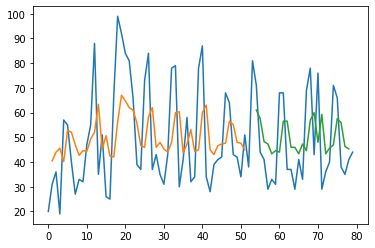

Epoch 1/40
 - 1s - loss: 0.2402
Epoch 2/40
 - 0s - loss: 0.1873
Epoch 3/40
 - 0s - loss: 0.1480
Epoch 4/40
 - 0s - loss: 0.1179
Epoch 5/40
 - 0s - loss: 0.0974
Epoch 6/40
 - 0s - loss: 0.0851
Epoch 7/40
 - 0s - loss: 0.0780
Epoch 8/40
 - 0s - loss: 0.0754
Epoch 9/40
 - 0s - loss: 0.0734
Epoch 10/40
 - 0s - loss: 0.0725
Epoch 11/40
 - 0s - loss: 0.0719
Epoch 12/40
 - 0s - loss: 0.0710
Epoch 13/40
 - 0s - loss: 0.0699
Epoch 14/40
 - 0s - loss: 0.0696
Epoch 15/40
 - 0s - loss: 0.0693
Epoch 16/40
 - 0s - loss: 0.0684
Epoch 17/40
 - 0s - loss: 0.0674
Epoch 18/40
 - 0s - loss: 0.0669
Epoch 19/40
 - 0s - loss: 0.0666
Epoch 20/40
 - 0s - loss: 0.0658
Epoch 21/40
 - 0s - loss: 0.0654
Epoch 22/40
 - 0s - loss: 0.0650
Epoch 23/40
 - 0s - loss: 0.0643
Epoch 24/40
 - 0s - loss: 0.0641
Epoch 25/40
 - 0s - loss: 0.0646
Epoch 26/40
 - 0s - loss: 0.0628
Epoch 27/40
 - 0s - loss: 0.0629
Epoch 28/40
 - 0s - loss: 0.0621
Epoch 29/40
 - 0s - loss: 0.0618
Epoch 30/40
 - 0s - loss: 0.0619
Epoch 31/40
 - 0s -

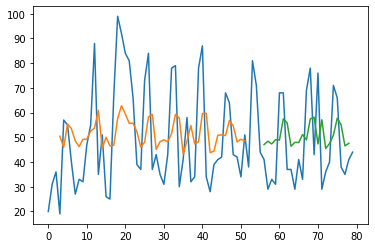

Epoch 1/40
 - 1s - loss: 0.1693
Epoch 2/40
 - 0s - loss: 0.1169
Epoch 3/40
 - 0s - loss: 0.0876
Epoch 4/40
 - 0s - loss: 0.0747
Epoch 5/40
 - 0s - loss: 0.0708
Epoch 6/40
 - 0s - loss: 0.0692
Epoch 7/40
 - 0s - loss: 0.0684
Epoch 8/40
 - 0s - loss: 0.0692
Epoch 9/40
 - 0s - loss: 0.0680
Epoch 10/40
 - 0s - loss: 0.0681
Epoch 11/40
 - 0s - loss: 0.0682
Epoch 12/40
 - 0s - loss: 0.0679
Epoch 13/40
 - 0s - loss: 0.0673
Epoch 14/40
 - 0s - loss: 0.0675
Epoch 15/40
 - 0s - loss: 0.0677
Epoch 16/40
 - 0s - loss: 0.0674
Epoch 17/40
 - 0s - loss: 0.0666
Epoch 18/40
 - 0s - loss: 0.0666
Epoch 19/40
 - 0s - loss: 0.0668
Epoch 20/40
 - 0s - loss: 0.0663
Epoch 21/40
 - 0s - loss: 0.0663
Epoch 22/40
 - 0s - loss: 0.0664
Epoch 23/40
 - 0s - loss: 0.0657
Epoch 24/40
 - 0s - loss: 0.0658
Epoch 25/40
 - 0s - loss: 0.0670
Epoch 26/40
 - 0s - loss: 0.0652
Epoch 27/40
 - 0s - loss: 0.0656
Epoch 28/40
 - 0s - loss: 0.0649
Epoch 29/40
 - 0s - loss: 0.0650
Epoch 30/40
 - 0s - loss: 0.0653
Epoch 31/40
 - 0s -

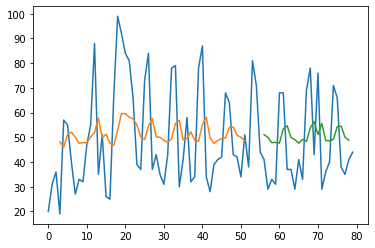

In [0]:
# LSTM Network for Regression
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 1, 
              epochs = 40)

# LSTM for Regression Using the Window Method
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 3, 
              epochs = 40)

# LSTM for Regression with Time Steps
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 3, 
              epochs = 40, 
              type_ = 'regression with time steps')

# # LSTM with Memory Between Batches
# do_lstm_model(df = df_prophet, 
#               ts = 'y', 
#               look_back = 3, 
#               epochs = 5, 
#               type_ = 'memory between batches')

# # Stacked LSTMs with Memory Between Batches
# do_lstm_model(df = df_prophet, 
#               ts = 'y', 
#               look_back = 3, 
#               epochs = 5, 
#               type_ = 'stacked with memory between batches')